In [32]:
import jax.numpy as jnp
import numpy as np
import os
from jax import jit
from functools import partial
import matplotlib.pyplot as plt

import appletree as apt
from appletree import flex
from appletree import ipm
from appletree import imm
from appletree.flex import randgen
from appletree.flex.plugin import *

In [3]:
apt.utils.set_gpu_memory_usage(0.2)
par_manager = ipm.ParManager()

#### Microphysics plugins

In [4]:
plugin1 = EnergySpectra(par_manager, 0.01, 20.)
plugin2 = Quenching(par_manager)
plugin3 = Ionization(par_manager)
plugin4 = mTI(par_manager)
plugin5 = RecombFluct(par_manager)
plugin6 = TrueRecomb(par_manager)
plugin7 = Recombination(par_manager)

#### Detector plugins

In [5]:
s1_lce_map = imm.MapRegBin(os.path.join(imm.DATAPATH, 's1_correction_map_regbin.json'))
s2_lce_map = imm.MapRegBin(os.path.join(imm.DATAPATH, 's2_correction_map_regbin.json'))
elife_map = imm.Map(os.path.join(imm.DATAPATH, 'elife.json'))

plugin8 = PositionSpectra(par_manager)
plugin9 = S1Correction(par_manager, s1_lce_map)
plugin10 = S2Correction(par_manager, s2_lce_map)
plugin11 = PhotonDetection(par_manager)
plugin12 = S1PE(par_manager)
plugin13 = DriftLoss(par_manager, elife_map)
plugin14 = ElectronDrifted(par_manager)
plugin15 = S2PE(par_manager)

#### Reconstruction plugins

In [11]:
s1_bias = imm.Map(os.path.join(imm.DATAPATH, 's1_bias.json'))
s1_smear = imm.Map(os.path.join(imm.DATAPATH, 's1_smearing.json'))
s2_bias = imm.Map(os.path.join(imm.DATAPATH, 's2_bias.json'))
s2_smear = imm.Map(os.path.join(imm.DATAPATH, 's2_smearing.json'))

plugin16 = S1(par_manager, s1_bias, s1_smear)
plugin17 = S2(par_manager, s2_bias, s2_smear)
plugin18 = cS1(par_manager)
plugin19 = cS2(par_manager)

#### Efficiency plugins

In [13]:
s1_eff = imm.Map(os.path.join(imm.DATAPATH, '3fold_recon_eff.json'))

plugin20 = S2Threshold(par_manager)
plugin21 = S1ReconEff(par_manager, s1_eff)

# Pipeline

In [14]:
@apt.utils.timeit
@partial(jit, static_argnums=(1, ))
def sim(key, n):
    key, energy = plugin1(key, n)
    key, n_q = plugin2(key, energy)
    key, n_i = plugin3(key, n_q)
    key, r_mean = plugin4(key, energy)
    key, r_std = plugin5(key, energy)
    key, r = plugin6(key, r_mean, r_std)
    key, n_ph, n_e = plugin7(key, n_q, n_i, r)
    
    key, x, y, z = plugin8(key, n)
    key, s1_correction = plugin9(key, x, y, z)
    key, s2_correction = plugin10(key, x, y)
    key, n_s1_phd = plugin11(key, n_ph, s1_correction)
    key, n_s1_pe = plugin12(key, n_s1_phd)
    key, surv_prob = plugin13(key, z)
    key, n_e_drifted = plugin14(key, n_e, surv_prob)
    key, n_s2_pe = plugin15(key, n_e_drifted, s2_correction)
    
    key, s1 = plugin16(key, n_s1_phd, n_s1_pe)
    key, s2 = plugin17(key, n_s2_pe)
    key, cs1 = plugin18(key, s1, s1_correction)
    key, cs2 = plugin19(key, s2, s2_correction, surv_prob)
    
    key, acc_s2_threshold = plugin20(key, s2)
    key, acc_s1_recon_eff = plugin21(key, n_s1_phd)
    
    eff = acc_s2_threshold*acc_s1_recon_eff
    
    hist, be = jnp.histogramdd(
        jnp.asarray([cs1, cs2]).T,
        bins=(jnp.linspace(0,100,101), jnp.logspace(2.5,4.1,81)),
        weights=eff
    )
    
    return key, hist, be

In [15]:
batch_size = int(1e6)
key = flex.randgen.get_key()

#### Build

In [26]:
key, hist, be = sim(key, batch_size)

 Function <sim> starts. 
 Function <sim> ends! Time cost = 3.471851 msec. 


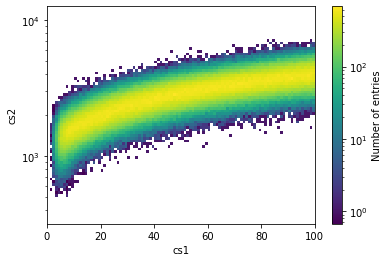

In [27]:
import numpy as np
import multihist as mh
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

hist = mh.Histdd.from_histogram(
    np.array(hist), 
    be, 
    axis_names=['cs1', 'cs2']
)
hist.plot(norm=LogNorm())
plt.yscale('log')
plt.show()

#### Speed test

In [33]:
@apt.utils.timeit
def benchmark():
    key = randgen.get_key()
    for itr in range(100):
        key, _, _ = sim(key, int(1e6))

In [34]:
benchmark()

 Function <benchmark> starts. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 3.857851 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 2.415419 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 9.947538 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 16.908646 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.529249 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 15.424013 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 15.437126 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.357639 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.141870 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 16.897202 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 15.310049 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.514467 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 1